In [75]:
import numpy as np
from numba import njit
from qnute.hamiltonian import Hamiltonian
from qnute.hamiltonian.laplacian import generateLaplaceHamiltonian1D
from qnute.simulation.numerical_sim import qnute
from qnute.simulation.numerical_sim import get_theoretical_evolution as get_qnute_th_evolution
from qnute.simulation.parameters import QNUTE_params as Params
from qnute.simulation.output import QNUTE_output as Output
import matplotlib.pyplot as plt

import logging

@njit
def get_theoretical_evolution(L:float,Nx:int,dx:float,Nt:int,dt:float, 
                              sv_sample_indices:np.ndarray,
                              homogeneous_flag:bool=False):
    if not homogeneous_flag:
        theoretical_solution = np.zeros((Nt+1,Nx), dtype=np.float64)
        x = np.arange(Nx)*dx + dx
        for i,t in enumerate(np.arange(Nt+1)*dt):
            theoretical_solution[i,:] = np.sin(np.pi*x/L) * np.exp(-np.power(np.pi/L,2)*t)
        return theoretical_solution
    else:
        theoretical_solution = np.ones(((Nt+1),Nx), dtype=np.float64)
        x = np.arange(Nx//2)*dx + dx
        for i,t in enumerate(np.arange(Nt+1)*dt):
            theoretical_solution[i,sv_sample_indices] = np.sin(np.pi*x/L) * np.exp(-np.power(np.pi/L,2)*t)
        return theoretical_solution

logging.getLogger().setLevel(logging.INFO)
n = 5
# qubit_map = {(i,):(i) for i in range(n)}
qubit_map = {(i,):(i+1)%n for i in range(n)}
# D = 2
# u_domains = [[i,i+1] for i in range(n-1)]

D = 6
u_domains = [list(range(i,np.min([i+D, n]))) for i in range(np.max([n-D+1, 1]))]


# qubit_map = {(0,):1, (1,):2, (2,):3, (3,):4, (4,):0}
# sv_sample_indices = np.array([0,1,2,3])
sv_sample_indices = np.arange(2**(n-1))
sv_extra_indices = np.array([i for i in range(2**n) if i not in sv_sample_indices])
homogeneous_flag = False

Nx = 2**n
# L = 1.0
# dx = L / (Nx+1)
dx = 0.1
L = dx * (Nx+1)
if homogeneous_flag:
    L = dx * (Nx//2 + 1)
T = 0.5

dtau = 0.1
Ntau = np.int32(np.ceil(T / dtau))
dt = dtau*dx*dx
Nt = np.int32(np.ceil(T/dt))

print(f'Nt = {Nt}, Ntau = {Ntau}')

delta = 0.1
num_shots=0
backend=None
trotter_flag = True

H = generateLaplaceHamiltonian1D(n, 0, 1.0, False, homogeneous_flag)
print(H)
print(H.pterm_list)
# print(H.hm_indices)
print(np.real(H.get_matrix()))

# print(H.get_hm_pterms(0))
# norm = np.linalg.norm(H.pterm_list['amplitude'])
# print(f"norm = {norm:0.5f}\n")
# print(np.real(H.get_matrix())/norm)

times = np.arange(Nt+1)*dt
x = np.arange((Nx if not homogeneous_flag else Nx//2)+2)*dx
f = np.zeros(x.shape,dtype=np.complex128)
theoretical_solution = get_theoretical_evolution(L,Nx,dx,Nt,dt,
                                                    sv_sample_indices,
                                                    homogeneous_flag)

psi0 = theoretical_solution[0,:].copy()
print()
print(psi0)
c0 = np.linalg.norm(psi0)
c_prime = np.sqrt(np.sum(np.power(psi0[sv_sample_indices],2)) + np.power(2,n-1))
print(f'c0={c0}\nc1={c_prime}')
psi0 /= c0
print(psi0)
print(psi0/psi0[-1])

params = Params(H, 1, n, qubit_map)
params.load_hamiltonian_params(D, u_domains, False, True)
params.set_run_params(dtau, delta, Nt, num_shots, backend, init_sv=psi0,trotter_flag=trotter_flag)


Nt = 500, Ntau = 5
Hamiltonian Pauli Terms and Amplitudes:

	I_4 I_3 I_2 I_1 X_0  : (1.00000+0.00000j)

	I_4 I_3 I_2 X_1 X_0  : (0.50000+0.00000j)
	I_4 I_3 I_2 Y_1 Y_0  : (0.50000+0.00000j)

	I_4 I_3 X_2 X_1 X_0  : (0.25000+0.00000j)
	I_4 I_3 X_2 Y_1 Y_0  : (-0.25000+0.00000j)
	I_4 I_3 Y_2 X_1 Y_0  : (0.25000+0.00000j)
	I_4 I_3 Y_2 Y_1 X_0  : (0.25000+0.00000j)

	I_4 X_3 X_2 X_1 X_0  : (0.12500+0.00000j)
	I_4 X_3 X_2 Y_1 Y_0  : (-0.12500+0.00000j)
	I_4 X_3 Y_2 X_1 Y_0  : (-0.12500+0.00000j)
	I_4 X_3 Y_2 Y_1 X_0  : (-0.12500+0.00000j)
	I_4 Y_3 X_2 X_1 Y_0  : (0.12500+0.00000j)
	I_4 Y_3 X_2 Y_1 X_0  : (0.12500+0.00000j)
	I_4 Y_3 Y_2 X_1 X_0  : (0.12500+0.00000j)
	I_4 Y_3 Y_2 Y_1 Y_0  : (-0.12500+0.00000j)

	X_4 X_3 X_2 X_1 X_0  : (0.06250+0.00000j)
	X_4 X_3 X_2 Y_1 Y_0  : (-0.06250+0.00000j)
	X_4 X_3 Y_2 X_1 Y_0  : (-0.06250+0.00000j)
	X_4 X_3 Y_2 Y_1 X_0  : (-0.06250+0.00000j)
	X_4 Y_3 X_2 X_1 Y_0  : (-0.06250+0.00000j)
	X_4 Y_3 X_2 Y_1 X_0  : (-0.06250+0.00000j)
	X_4 Y_3 Y_2 X_1 X_0  :

In [76]:

out = qnute(params,log_frequency=100,c0=c0)
# print(len(out.c_list))

print('Final State:')
print(out.svs[-1,:])

# qnute_svs = get_qnute_th_evolution(np.real(H.get_matrix()), psi0, dtau, Ntau)

fig,axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,4))

for i,t in enumerate(times):
    f[1:(Nx if not homogeneous_flag else Nx//2)+1] = theoretical_solution[i, np.arange(Nx) if not homogeneous_flag else sv_sample_indices]
    l, =axs[0].plot(x, f,label=f't={t:0.3f}')
# taus = np.arange(Ntau+1)*dtau
# for i,t in enumerate(times):
    f[1:(Nx if not homogeneous_flag else Nx//2)+1] = np.real(out.svs[i, np.arange(Nx) if not homogeneous_flag else sv_sample_indices]) * (np.prod(out.c_list[0:i+1]) if not homogeneous_flag else (1.0 / np.mean(out.svs[sv_extra_indices]) ))
    axs[1].plot(x,
                f,
                label=f'tau={t:0.3f}', color=l.get_color())
    # axs[1].plot(x,qnute_svs[i,:], label=f'tau={t:0.3f}')

axs[0].set_title('Theoretical Evolution')
axs[1].set_title('QNUTE Evolution')
for ax in axs:
    ax.grid(True)
plt.xlim(-0.01,L + 0.01)
plt.xticks(np.arange(0.0,L+0.01,dx))
plt.ylim(-0.01, 1.01)
plt.show()

INFO:root:Performing initial measurements...
INFO:root:Starting QNUTE Iterations:
INFO:root:    Iteration 001
INFO:root:      Finished in 3.22 seconds.
INFO:root:    Iteration 002
INFO:root:      Finished in 2.64 seconds.
INFO:root:    Iteration 003
INFO:root:      Finished in 2.64 seconds.
INFO:root:    Iteration 004
INFO:root:      Finished in 2.95 seconds.
INFO:root:    Iteration 005
INFO:root:      Finished in 2.77 seconds.
INFO:root:    Iteration 006
INFO:root:      Finished in 2.64 seconds.
INFO:root:    Iteration 007
INFO:root:      Finished in 2.62 seconds.
INFO:root:    Iteration 008
INFO:root:      Finished in 2.67 seconds.
INFO:root:    Iteration 009
INFO:root:      Finished in 2.72 seconds.
INFO:root:    Iteration 010
INFO:root:      Finished in 2.64 seconds.
INFO:root:    Iteration 011
INFO:root:      Finished in 2.81 seconds.
INFO:root:    Iteration 012
INFO:root:      Finished in 2.70 seconds.
INFO:root:    Iteration 013
INFO:root:      Finished in 2.66 seconds.
INFO:roo

KeyboardInterrupt: 

In [61]:
u_domains

[[0, 1, 2, 3]]

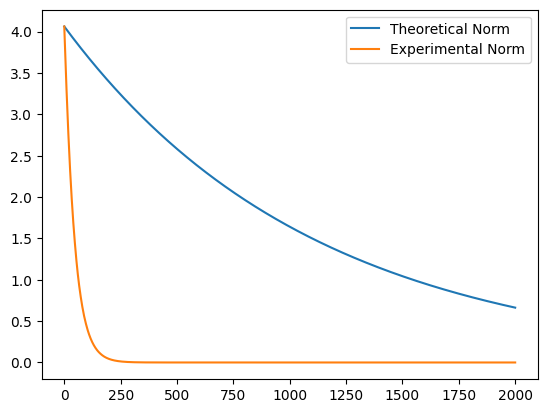

Rate of ratio growth = 0.029920076543156256


In [58]:
from qnute.helpers import exp_mat_psi

theory_norms = np.zeros(len(out.c_list),dtype=np.float64)
expt_norms =  np.zeros(len(out.c_list),dtype=np.float64)
for i,f in enumerate(theoretical_solution):
    theory_norms[i] = np.linalg.norm(f)
    expt_norms[i] = np.prod(out.c_list[0:i+1])
# for i,psi in enumerate(out.svs):
#     # if i == 0:
#         # continue
#     theory_norms[i] = np.sqrt(np.vdot(psi, exp_mat_psi(2.0*dtau*H.get_matrix(), psi)))
plt.plot(np.arange(len(out.c_list)), theory_norms, label='Theoretical Norm')
plt.plot(np.arange(len(out.c_list)), expt_norms, label='Experimental Norm')
# plt.plot(np.arange(len(out.c_list)), theory_norms/expt_norms, label='Ratio of Theory to Experiment')
beta = np.log(theory_norms[-1]/expt_norms[-1])/1600
# plt.plot(np.arange(len(out.c_list)), np.exp(beta*np.arange(len(out.c_list))), label='Exponential approximation of ratio')
# plt.plot(np.arange(len(out.c_list)-1), theory_norms, label='thry')
# plt.ylim([0,1])
plt.legend()
plt.show()
print(f'Rate of ratio growth = {beta}')


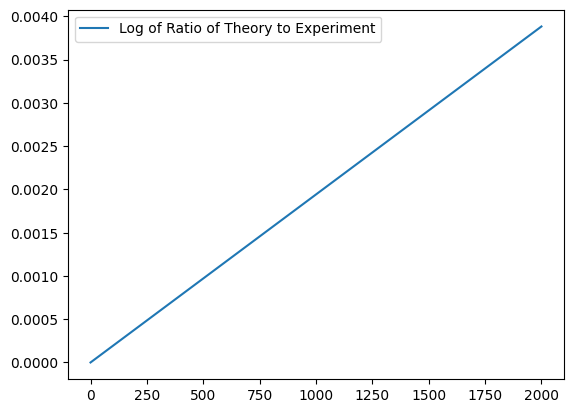

In [48]:
plt.plot(np.arange(len(out.c_list)), np.log(theory_norms/expt_norms), label='Log of Ratio of Theory to Experiment')
plt.legend()
plt.show()

In [53]:
epsilon_min = np.power(2*params.H.pterm_list.shape[0]*np.max(np.abs(params.H.pterm_list['amplitude']))*dtau, 2)/2.0
np.sqrt(np.exp(np.sqrt(2*epsilon_min)))

24.532530197109352

In [ ]:
theory_norms

In [ ]:
epsilons = np.array(out.c_list[1:])/theory_norms[1:] - 1.0
A = np.zeros(Nt, dtype=np.float64)
B = np.zeros(Nt, dtype=np.float64)

E = np.zeros((Nt,Nt),dtype=np.float64)
E[0,:] = 1.0
E[1,:] = [np.sum(epsilons[0:i+1]) for i in range(Nt)]

for i,e in enumerate(epsilons):
    A[i] = np.prod(1.0+epsilons[0:i+1]) - 1.0
    # B[i] = np.sum(epsilons[0:i+1])


# plt.plot(np.arange(epsilons.shape[0]), epsilons)
plt.plot(np.arange(epsilons.shape[0]), np.abs(A), label='True Relative Error')
plt.plot(np.arange(epsilons.shape[0]), np.abs(E[1]), label='Our Error Bound')
plt.legend()

In [ ]:
theory_norms = np.linalg.norm(theoretical_solution,axis=1)
expt_norms = np.zeros(theory_norms.shape,dtype=np.float64)
for i,c in enumerate(out.c_list):
    expt_norms[i] = np.prod(out.c_list[0:i+1])

In [ ]:
# plt.plot(np.arange(Nt+1), theory_norms)
# plt.plot(np.arange(Nt+1), expt_norms)
# plt.plot(np.arange(Nt+1), theory_norms[0]*np.exp(-(np.pi/L)**2 * np.arange(Nt+1)*dt))
plt.plot(np.arange(Nt+1), theory_norms / expt_norms)
plt.show()

In [ ]:
for i,c in enumerate(expt_norms):
    if i%100 == 0:
        print(f'{i:5d} - Theory: {theory_norms[i]:0.4e} | Expt: {c:0.4e} | Ratio: {theory_norms[i]/c:0.4e} | |Difference|: {np.abs(theory_norms[i]-c):0.4e}')

In [ ]:
factor = 2
dt2 = factor*dtau*dx*dx
Nt2 = np.int32(np.ceil(T/dt2))
params.set_run_params(dtau*factor, delta, Nt2, num_shots, backend, init_sv=psi0, trotter_flag=trotter_flag)
out2 = qnute(params, log_frequency=10, c0=c0)

In [ ]:
c_corrected = np.zeros(len(out2.c_list), dtype=np.float64)
c_corrected[0] = c0
for i in range(1,len(out2.c_list)):
    c_corrected[i] = ((out.c_list[2*i - 1]*out.c_list[2*i])*factor*factor - out2.c_list[i])/(factor*factor - 1.0)
    print(i)
# c_corrected = (np.array(out.c_list[::factor])*factor*factor - np.array(out2.c_list))/(factor*factor - 1.0)
k=1
c_corrected[k],theory_norms[k]

corrected_norms = np.zeros(c_corrected.shape,dtype=np.float64)
for i,c in enumerate(c_corrected):
    corrected_norms[i] = np.prod(c_corrected[0:i+1])

In [ ]:
plt.plot(np.arange(Nt2+1), theory_norms[::factor])
plt.plot(np.arange(Nt2+1), corrected_norms)
plt.plot(np.arange(Nt2+1), expt_norms[::factor])

In [ ]:
plt.plot(np.arange(Nt2+1), corrected_norms/theory_norms[::factor])